<a href="https://colab.research.google.com/github/danteaguirreb/machine_learning/blob/tareas/Tarea_Final_ML_VC_FM_DA_v_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2 – Modelamiento supervisado y no supervisado

Este notebook sigue la estructura solicitada en el enunciado de la tarea:

## 1. Exploración y diagnóstico de datos
- Descripción del dataset y de la variable objetivo (`Revenue`).
- Análisis exploratorio y correlación entre variables numéricas.
- Análisis de colinealidad, identificación de bloques y selección de variables representativas.
- Limpieza y diagnóstico de calidad del dataset.

## 2. Modelos supervisados
- Regresión logística (enfoque predictivo con scikit-learn).
- Regresión logística (enfoque inferencial con statsmodels).
- Modelos comparativos: LDA, KNN y Naive Bayes.
- Evaluación mediante métricas para clase rara y matrices de confusión.

## 3. Fronteras de decisión en 2D
- Selección de dos variables originales.
- Visualización de fronteras de decisión de Regresión Logística y Naive Bayes.
- Interpretación geométrica.

## 4. Modelos no supervisados
- K-Means: selección de k con método del codo y silhouette.
- GMM: selección de número de componentes con BIC/AIC.
- Clustering jerárquico: dendrograma y corte.
- Self-Organizing Maps (SOM): U-Matrix, mapa de hits y mapa de `Revenue`.

## 5. Integración final
- Síntesis de variables más relevantes.
- Comparación de desempeño entre modelos supervisados.
- Relación entre clusters y `Revenue`.
- Propuestas de acciones de negocio basadas en los hallazgos.


# Tarea Final – Métodos Estadísticos / Machine Learning  
**Online Shoppers Purchasing Intention Dataset**  

Este notebook sigue punto por punto el enunciado de la tarea: exploración, modelos supervisados (RegLog, LDA, KNN, Naive Bayes), fronteras de decisión en 2D y modelos no supervisados (K-Means, GMM, clustering jerárquico y SOM).  

> **Importante:** Ajusta la ruta del dataset en la celda de carga de datos y revisa/ajusta la selección de variables (`selected_features` y `feature_pair`) según tu propio análisis de colinealidad y relevancia.


## 0. Setup e importación de librerías

In [1]:
!pip install MiniSom
# !pip install statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Opcional: para heatmaps más cómodos
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, silhouette_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Para regresión logística inferencial
import statsmodels.api as sm

# Self-Organizing Maps (asegúrate de tener MiniSom instalado en tu entorno)
try:
    from minisom import MiniSom
    minisom_available = True
except ImportError:
    minisom_available = False
    print("MiniSom no está instalado. La sección SOM funcionará solo si instalas la librería minisom.")

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=01bfb46cc94b3e69b1f4d69615671ead0961897ba3cd54f8869d0aa85f39fe32
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built MiniSom


## 1. Carga y exploración inicial de datos

Usaremos el dataset **Online Shoppers Purchasing Intention Dataset**.  
Ajusta la ruta del archivo según donde lo tengas guardado.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imakash3011/online-shoppers-purchasing-intention-dataset")

print("Path to dataset files:", path)

100%|██████████| 252k/252k [00:00<00:00, 11.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/imakash3011/online-shoppers-purchasing-intention-dataset/versions/1


In [3]:
import os

# Define the actual dataset file name
data_path = 'online_shoppers_intention.csv'

# Construct the full file path using the previously obtained path and the dataset file name.
file_path = os.path.join(path, data_path)
df = pd.read_csv(file_path)

# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
# Distribución de la variable objetivo Revenue
if 'Revenue' not in df.columns:
    raise ValueError("No se encontró la columna 'Revenue' en el dataset. Revisa los nombres de las columnas.")

print(df['Revenue'].value_counts(dropna=False))
print("\nProporciones:")
print(df['Revenue'].value_counts(normalize=True))

Revenue
False    10422
True      1908
Name: count, dtype: int64

Proporciones:
Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64


In [5]:
# Definimos variable objetivo (y) y matriz de características (X)
y_raw = df['Revenue']

# Convertimos Revenue a 0/1 de forma flexible
if y_raw.dtype == 'bool':
    y = y_raw.astype(int)
else:
    mapping = {False: 0, True: 1, 'FALSE': 0, 'TRUE': 1, 'False': 0, 'True': 1, 0: 0, 1: 1}
    y = y_raw.map(mapping)
    if y.isna().any():
        raise ValueError("No se pudo mapear 'Revenue' limpiamente a 0/1. Revisa los valores únicos.")

X = df.drop(columns=['Revenue'])

numeric_cols = X.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Columnas numéricas:", numeric_cols)
print("Columnas categóricas:", categorical_cols)

Columnas numéricas: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']
Columnas categóricas: ['Month', 'VisitorType']


### 1.1 Descripción de las variables (incluyendo `Revenue`)

En esta sección, el foco es:

- Identificar tipos de variables (numéricas vs categóricas).  
- Entender la variable objetivo `Revenue` (clase rara o no, proporciones).  
- Mirar rangos, posibles outliers y valores faltantes.

Ejecuta las celdas siguientes y escribe un resumen en texto según los resultados que observes.


In [6]:
# Resumen estadístico de variables numéricas
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


In [7]:
# Variables categóricas: niveles más frecuentes
for col in categorical_cols:
    print(f"\nColumna categórica: {col}")
    print(df[col].value_counts(dropna=False).head(10))


Columna categórica: Month
Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

Columna categórica: VisitorType
VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64



### 1.2 Limpieza de datos y diagnóstico de calidad

En esta sección se revisa con mayor detalle la **calidad del dataset** antes del modelamiento:

- Búsqueda de valores faltantes por variable.
- Identificación de filas duplicadas.
- Revisión de rangos y estadísticos básicos de variables numéricas.
- Distribución de las principales variables categóricas.

El objetivo es documentar explícitamente que los modelos se construyen sobre un conjunto de datos **consistente y razonable**, y dejar en evidencia cualquier supuesto adicional que se haya tomado (por ejemplo, ausencia de outliers extremos o necesidad de transformaciones).


In [8]:

# Diagnóstico general de calidad de datos

print("Dimensiones del dataset:", df.shape)
print("\nValores faltantes por columna:")
print(df.isna().sum())

# Duplicados exactos
n_dup = df.duplicated().sum()
print(f"\nNúmero de filas duplicadas exactas: {n_dup}")

if n_dup > 0:
    print("Opcional: podrías considerar eliminar duplicados con df.drop_duplicates().")

# Resumen de variables numéricas
print("\nResumen estadístico de variables numéricas:")
display(df.select_dtypes(include=['int64', 'float64', 'bool']).describe().T)

# Distribución de algunas variables categóricas (si existen)
cat_cols_global = df.select_dtypes(include=['object']).columns.tolist()
if cat_cols_global:
    print("\nDistribución de las principales variables categóricas (top 10 niveles):")
    for col in cat_cols_global:
        print(f"\nColumna categórica: {col}")
        display(df[col].value_counts(dropna=False).head(10))
else:
    print("\nNo se detectaron columnas categóricas de tipo object en df.")


Dimensiones del dataset: (12330, 18)

Valores faltantes por columna:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Número de filas duplicadas exactas: 125
Opcional: podrías considerar eliminar duplicados con df.drop_duplicates().

Resumen estadístico de variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000



Distribución de las principales variables categóricas (top 10 niveles):

Columna categórica: Month


,count
Month,
May,3364
Nov,2998
Mar,1907
Dec,1727
Oct,549
Sep,448
Aug,433
Jul,432
June,288



Columna categórica: VisitorType


,count
VisitorType,
Returning_Visitor,10551
New_Visitor,1694
Other,85


### 1.2 Matriz de correlación y heatmap triangular

- Calculamos la matriz de correlación de las variables **numéricas**.  
- Graficamos un **heatmap triangular**:  
  - Triángulo inferior: colores de correlación.  
  - Triángulo superior: valores numéricos en formato compacto.


In [9]:
# Matriz de correlación
corr = df[numeric_cols].corr()
corr

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend
Administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,-0.223563,-0.316483,0.098990,-0.094778,-0.006347,-0.025035,-0.005487,-0.033561,0.026417
Administrative_Duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,-0.144170,-0.205798,0.067608,-0.073304,-0.007343,-0.015392,-0.005561,-0.014376,0.014990
Informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,-0.116114,-0.163666,0.048632,-0.048219,-0.009527,-0.038235,-0.029169,-0.034491,0.035785
Informational_Duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,-0.074067,-0.105276,0.030861,-0.030577,-0.009579,-0.019285,-0.027144,-0.024675,0.024078
ProductRelated,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,-0.204578,-0.292526,0.056282,-0.023958,0.004290,-0.013146,-0.038122,-0.043064,0.016092
ProductRelated_Duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,-0.184541,-0.251984,0.052823,-0.036380,0.002976,-0.007380,-0.033091,-0.036377,0.007311
BounceRates,-0.223563,-0.144170,-0.116114,-0.074067,-0.204578,-0.184541,1.000000,0.913004,-0.119386,0.072702,0.023823,-0.015772,-0.006485,0.078286,-0.046514
ExitRates,-0.316483,-0.205798,-0.163666,-0.105276,-0.292526,-0.251984,0.913004,1.000000,-0.174498,0.102242,0.014567,-0.004442,-0.008907,0.078616,-0.062587
PageValues,0.098990,0.067608,0.048632,0.030861,0.056282,0.052823,-0.119386,-0.174498,1.000000,-0.063541,0.018508,0.045592,0.011315,0.012532,0.012002
SpecialDay,-0.094778,-0.073304,-0.048219,-0.030577,-0.023958,-0.036380,0.072702,0.102242,-0.063541,1.000000,0.012652,0.003499,-0.016098,0.052301,-0.016767


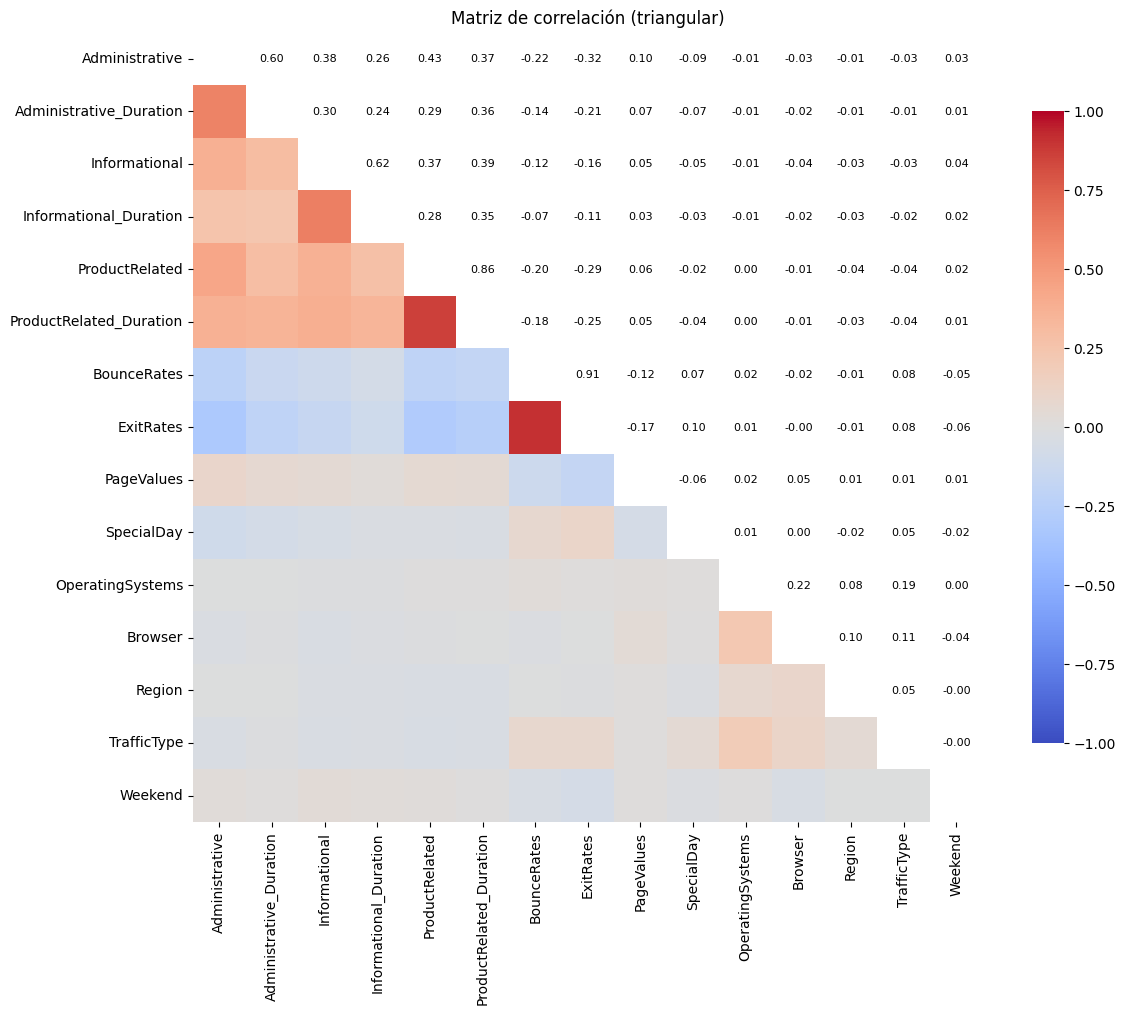

In [10]:
# Heatmap triangular de correlación
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))  # máscara para triángulo superior

# Triángulo inferior con colores
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    square=True,
    cbar_kws={"shrink": 0.8},
    vmin=-1, vmax=1
)

# Triángulo superior con valores numéricos
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i < j:
            plt.text(
                j + 0.5,
                i + 0.5,
                f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center",
                fontsize=8
            )

plt.title("Matriz de correlación (triangular)")
plt.tight_layout()
plt.show()


### 1.3 Análisis exhaustivo de colinealidad y selección de variables

En esta sección se realiza un **análisis más detallado de colinealidad** entre las variables numéricas:

1. Se calcula la matriz de correlación de Pearson entre todas las variables numéricas.
2. Se identifican pares de variables con **correlación absoluta alta** (por ejemplo, |r| > 0.8).
3. Se forman bloques de colinealidad y se selecciona una **variable representativa** por bloque, utilizando como criterio la menor correlación promedio con el resto de las variables.
4. Se construye un resumen final de variables numéricas candidatas a ser usadas como predictores en modelos lineales (Regresión Logística, LDA).

Este análisis complementa el heatmap de correlación y deja explícita la justificación de por qué se descartan algunas variables numéricas altamente redundantes.


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
Administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,-0.223563,-0.316483,0.098990,-0.094778,-0.006347,-0.025035,-0.005487,-0.033561,0.026417,0.138917
Administrative_Duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,-0.144170,-0.205798,0.067608,-0.073304,-0.007343,-0.015392,-0.005561,-0.014376,0.014990,0.093587
Informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,-0.116114,-0.163666,0.048632,-0.048219,-0.009527,-0.038235,-0.029169,-0.034491,0.035785,0.095200
Informational_Duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,-0.074067,-0.105276,0.030861,-0.030577,-0.009579,-0.019285,-0.027144,-0.024675,0.024078,0.070345
ProductRelated,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,-0.204578,-0.292526,0.056282,-0.023958,0.004290,-0.013146,-0.038122,-0.043064,0.016092,0.158538
ProductRelated_Duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,-0.184541,-0.251984,0.052823,-0.036380,0.002976,-0.007380,-0.033091,-0.036377,0.007311,0.152373
BounceRates,-0.223563,-0.144170,-0.116114,-0.074067,-0.204578,-0.184541,1.000000,0.913004,-0.119386,0.072702,0.023823,-0.015772,-0.006485,0.078286,-0.046514,-0.150673
ExitRates,-0.316483,-0.205798,-0.163666,-0.105276,-0.292526,-0.251984,0.913004,1.000000,-0.174498,0.102242,0.014567,-0.004442,-0.008907,0.078616,-0.062587,-0.207071
PageValues,0.098990,0.067608,0.048632,0.030861,0.056282,0.052823,-0.119386,-0.174498,1.000000,-0.063541,0.018508,0.045592,0.011315,0.012532,0.012002,0.492569
SpecialDay,-0.094778,-0.073304,-0.048219,-0.030577,-0.023958,-0.036380,0.072702,0.102242,-0.063541,1.000000,0.012652,0.003499,-0.016098,0.052301,-0.016767,-0.082305


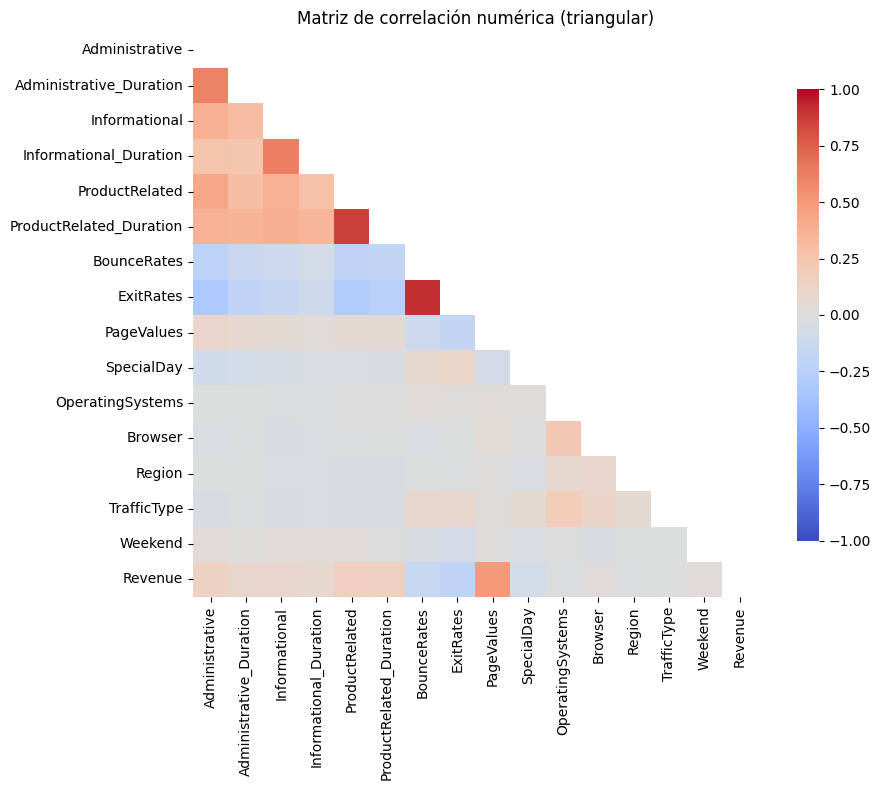

Pares con |correlación| > 0.8:
BounceRates - ExitRates: 0.913
ProductRelated - ProductRelated_Duration: 0.861

Variables numéricas seleccionadas (representantes + variables sin alta colinealidad):
['BounceRates', 'ProductRelated', 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend', 'Revenue']


,Variable,Tipo en análisis
5,ProductRelated_Duration,Descartada por colinealidad
7,ExitRates,Descartada por colinealidad
4,ProductRelated,Representante
6,BounceRates,Representante
0,Administrative,Sin alta colinealidad
1,Administrative_Duration,Sin alta colinealidad
2,Informational,Sin alta colinealidad
3,Informational_Duration,Sin alta colinealidad
8,PageValues,Sin alta colinealidad
9,SpecialDay,Sin alta colinealidad


In [11]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Aseguramos la lista de numéricas
numeric_cols_global = df.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

corr_global = df[numeric_cols_global].corr()
display(corr_global)

# Visualización tipo heatmap (triangular)
import seaborn as sns

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_global, dtype=bool))
sns.heatmap(corr_global, mask=mask, cmap="coolwarm", vmin=-1, vmax=1, square=True,
            cbar_kws={"shrink": 0.8})
plt.title("Matriz de correlación numérica (triangular)")
plt.tight_layout()
plt.show()

# Identificación de pares con alta colinealidad
threshold = 0.8
corr_abs = corr_global.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

high_corr_pairs = []
for row in upper.index:
    for col in upper.columns:
        value = upper.loc[row, col]
        if not pd.isna(value) and value > threshold:
            high_corr_pairs.append((row, col, value))

print(f"Pares con |correlación| > {threshold}:")
for a, b, v in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"{a} - {b}: {v:.3f}")

# Selección de representantes de bloques de colinealidad
to_drop = set()
representatives = []

for a, b, v in sorted(high_corr_pairs, key=lambda x: -x[2]):
    if a in to_drop or b in to_drop:
        continue
    # correlación promedio con el resto
    mean_a = corr_abs[a].mean()
    mean_b = corr_abs[b].mean()
    if mean_a <= mean_b:
        keep, drop = a, b
    else:
        keep, drop = b, a
    representatives.append(keep)
    to_drop.add(drop)

singletons = [c for c in numeric_cols_global if c not in to_drop and c not in representatives]
selected_numeric_features = representatives + singletons

print("\nVariables numéricas seleccionadas (representantes + variables sin alta colinealidad):")
print(selected_numeric_features)

# DataFrame resumen
summary_rows = []
for col in numeric_cols_global:
    if col in representatives:
        block = "Representante"
    elif col in to_drop:
        block = "Descartada por colinealidad"
    else:
        block = "Sin alta colinealidad"
    summary_rows.append({
        "Variable": col,
        "Tipo en análisis": block
    })

summary_colin = pd.DataFrame(summary_rows)
display(summary_colin.sort_values("Tipo en análisis"))



#### Resumen de variables seleccionadas

El cuadro anterior clasifica cada variable numérica en:

- **Representante:** elegida para permanecer en el conjunto de predictores por ser la más “específica” dentro de su bloque de alta correlación.
- **Descartada por colinealidad:** fuertemente redundante con otra variable del mismo bloque; se recomienda no incluirla simultáneamente en modelos lineales.
- **Sin alta colinealidad:** no presenta correlaciones absolutas superiores al umbral, por lo que puede mantenerse sin riesgo elevado de multicolinealidad.

En los modelos lineales posteriores (Regresión Logística y LDA) es recomendable utilizar preferentemente el subconjunto `selected_numeric_features`, complementado con las variables categóricas codificadas mediante one-hot encoding.


### 1.3 Bloques de colinealidad y selección de variables representativas

Usaremos una regla automática para detectar **bloques de alta colinealidad**:  
- Si |corr| > 0.8 entre dos variables, se considerarán altamente correlacionadas.  
- Haremos una selección greedly: mantendremos una sola variable representativa por bloque.

Luego puedes **revisar y ajustar** la lista `selected_features` según tu criterio de negocio / interpretabilidad.


In [12]:
# Detección simple de bloques de colinealidad (umbral 0.8)
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if not pd.isna(upper.loc[row, col]) and upper.loc[row, col] > 0.8
]

print("Pares altamente correlacionados (|corr| > 0.8):")
for a, b, v in high_corr_pairs:
    print(f"{a} - {b}: {v:.2f}")

Pares altamente correlacionados (|corr| > 0.8):
ProductRelated_Duration - ProductRelated: 0.86
ExitRates - BounceRates: 0.91


In [13]:
# Selección greedy de variables representativas por bloque de alta correlación
to_drop = set()
representatives = []

for col1, col2, v in sorted(high_corr_pairs, key=lambda x: -x[2]):
    if col1 in to_drop or col2 in to_drop:
        continue
    # Calculamos "importancia" relativa: correlación media con otras variables
    mean_corr1 = corr_abs[col1].mean()
    mean_corr2 = corr_abs[col2].mean()
    # Dejamos la que tenga menor correlación promedio (más específica)
    if mean_corr1 <= mean_corr2:
        keep, drop = col1, col2
    else:
        keep, drop = col2, col1
    representatives.append(keep)
    to_drop.add(drop)

# Variables numéricas no altamente correlacionadas (quedan solas)
singletons = [c for c in numeric_cols if c not in to_drop and c not in representatives]

auto_selected_features = representatives + singletons
print("Variables seleccionadas automáticamente (puedes ajustar):")
print(auto_selected_features)

Variables seleccionadas automáticamente (puedes ajustar):
['BounceRates', 'ProductRelated', 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']


In [14]:
# Define aquí la lista final de variables seleccionadas (ideal: 6–10)
# Puedes usar auto_selected_features como base y editarla a mano si quieres.
selected_features = auto_selected_features

print("Variables finales seleccionadas para modelos supervisados:")
print(selected_features)

Variables finales seleccionadas para modelos supervisados:
['BounceRates', 'ProductRelated', 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']


## 2. Modelos supervisados

Usaremos las variables seleccionadas en `selected_features` para ajustar:

- Regresión logística (sklearn, enfoque predictivo).  
- Regresión logística (statsmodels, enfoque inferencial).  
- Modelos comparativos: LDA, KNN, Naive Bayes Gaussiano.  

Seguiremos buenas prácticas CRISP-DM:
- **Train/test split estratificado** para evitar fuga de información.  
- **Pipeline** con `StandardScaler` y codificadores dentro del flujo de scikit-learn.  
- Múltiples métricas (accuracy, precision, recall, F1, AUC) y matriz de confusión.


In [15]:
# Subconjunto de datos con las variables seleccionadas
X_sub = X[selected_features]

# Re-definimos tipos para este subconjunto
numeric_cols_sub = X_sub.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
categorical_cols_sub = [c for c in X_sub.columns if c not in numeric_cols_sub]

print("Numéricas para modelos supervisados:", numeric_cols_sub)
print("Categóricas para modelos supervisados:", categorical_cols_sub)

Numéricas para modelos supervisados: ['BounceRates', 'ProductRelated', 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']
Categóricas para modelos supervisados: []


In [16]:
# Train / test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Distribución y_train:")
print(y_train.value_counts(normalize=True))

Shape X_train: (9864, 13)
Shape X_test: (2466, 13)
Distribución y_train:
Revenue
0    0.845296
1    0.154704
Name: proportion, dtype: float64


In [17]:
# Preprocesamiento: escalado en numéricas + one-hot en categóricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols_sub),
        ('cat', categorical_transformer, categorical_cols_sub)
    ]
)

### 2.1 Regresión Logística (sklearn – enfoque predictivo)

Construimos un `Pipeline` con:

- `preprocess` (escalado + one-hot)  
- `LogisticRegression` con `class_weight="balanced"` por el desbalance de clases.

Evaluamos en el set de test:
- Accuracy  
- Precision  
- Recall  
- F1  
- AUC (ROC-AUC)  
- Matriz de confusión


In [18]:
# Pipeline de Regresión Logística (sklearn)
log_reg_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

log_reg_clf.fit(X_train, y_train)

# Predicciones y probabilidades
y_pred_lr = log_reg_clf.predict(X_test)
y_proba_lr = log_reg_clf.predict_proba(X_test)[:, 1]

# Métricas
def evaluar_modelo(y_true, y_pred, y_proba, nombre="Modelo"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"\n=== {nombre} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    return acc, prec, rec, f1, auc

metrics_lr = evaluar_modelo(y_test, y_pred_lr, y_proba_lr, nombre="Regresión Logística (sklearn)")


=== Regresión Logística (sklearn) ===
Accuracy : 0.8642
Precision: 0.5471
Recall   : 0.7147
F1       : 0.6198
ROC-AUC  : 0.8641


In [19]:
# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr

array([[1858,  226],
       [ 109,  273]])

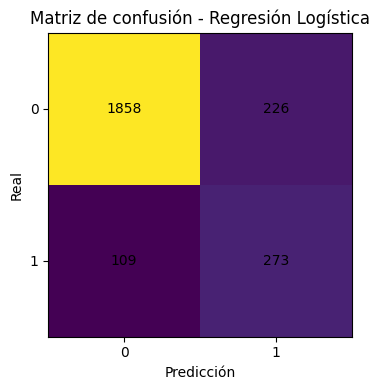

In [20]:
plt.figure(figsize=(4, 4))
plt.imshow(cm_lr, interpolation='nearest')
plt.title("Matriz de confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_lr[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

### 2.2 Regresión Logística (statsmodels – enfoque inferencial)

Usamos las mismas variables seleccionadas, pero ahora:

- Codificamos categóricas con `pandas.get_dummies` (one-hot).  
- Ajustamos un modelo `Logit` de `statsmodels`.  
- Reportamos coeficientes, errores estándar, estadístico z y p-valores mediante `summary()`.

Luego comparamos conceptualmente los resultados inferenciales con el desempeño predictivo anterior.


In [21]:
# Preparamos datos para statsmodels (get_dummies en X_train)
X_train_sm = pd.get_dummies(X_train, drop_first=True)
X_test_sm = pd.get_dummies(X_test, drop_first=True)

# Alineamos columnas por si get_dummies generó columnas distintas entre train y test
X_train_sm, X_test_sm = X_train_sm.align(X_test_sm, join='left', axis=1, fill_value=0)

# Aseguramos que todas las columnas sean numéricas para statsmodels
X_train_sm = X_train_sm.astype(float)
X_test_sm = X_test_sm.astype(float)

X_train_sm_const = sm.add_constant(X_train_sm)

logit_model = sm.Logit(y_train, X_train_sm_const)
logit_result = logit_model.fit(disp=False)

logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Revenue   No. Observations:                 9864
Model:                          Logit   Df Residuals:                     9850
Method:                           MLE   Df Model:                           13
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.3088
Time:                        02:21:21   Log-Likelihood:                -2937.1
converged:                       True   LL-Null:                       -4249.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.3561      0.118    -20.049      0.000      -2.586      -2.126
BounceRates               -20.5230      2.764     -7.426      0.000     -25.940     -15.106
ProductRelated              0.0059      0.001      8.472      0.000       0.005       0.007
Administrative              0.0095      0.012      0.807      0.420      -0.014       0.033
Administrative_Duration     0.0001      0.000      0.705      0.481      -0.000       0.001
Informational               0.0366      0.030      1.214      0.225      -0.022       0.096
Informational_Duration  -3.082e-05      0.000     -0.124      0.901      -0.001       0.000
PageValues                  0.0847      0.003     32.265      0.000       0.080       0.090
SpecialDay                 -1.1070      0.251     -4.404      0.000      -1.600      -0.614
OperatingSystems           -0.0953      0.042     -2.257      0.024      -0.178      -0.013
Browser                     0.0204      0.021      0.993      0.321      -0.020       0.061
Region                     -0.0115      0.015     -0.793      0.428      -0.040       0.017
TrafficType                 0.0123      0.009      1.350      0.177      -0.006       0.030
Weekend                     0.2179      0.078      2.784      0.005       0.065       0.371
===========================================================================================
"""

In [22]:
# Predicciones de statsmodels (usando probabilidad y umbral 0.5)
X_test_sm_const = sm.add_constant(X_test_sm, has_constant='add')
y_proba_sm = logit_result.predict(X_test_sm_const)
y_pred_sm = (y_proba_sm >= 0.5).astype(int)

metrics_sm = evaluar_modelo(y_test, y_pred_sm, y_proba_sm, nombre="Regresión Logística (statsmodels)")


=== Regresión Logística (statsmodels) ===
Accuracy : 0.8788
Precision: 0.7318
Recall   : 0.3429
F1       : 0.4670
ROC-AUC  : 0.8602


> **Comentario sugerido:**  
> Compara la dirección y magnitud de los coeficientes (signos, significancia estadística) con las variables que parecen más relevantes en el desempeño predictivo. Comenta si las variables estadísticamente significativas son también importantes para la capacidad de detección de la clase positiva.


### 2.3 Modelos comparativos: LDA, KNN, Naive Bayes Gaussiano

Entrenaremos y compararemos:

- **LDA** (`LinearDiscriminantAnalysis`).  
- **KNN** (`KNeighborsClassifier` con `GridSearchCV` sobre `n_neighbors` y `weights`).  
- **Naive Bayes Gaussiano** (`GaussianNB`).  

Para cada modelo:
- Entrenamos con el mismo `train/test` que la RegLog.  
- Calculamos métricas (accuracy, precision, recall, F1, ROC-AUC).  
- Mostramos matriz de confusión.  
- Finalmente discutimos cuál detecta mejor la clase positiva (`Revenue = 1`).  


In [23]:
# LDA
lda_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LinearDiscriminantAnalysis())
])

lda_clf.fit(X_train, y_train)
y_pred_lda = lda_clf.predict(X_test)
# LDA permite decision_function, pero usamos predict_proba si está disponible
if hasattr(lda_clf.named_steps['model'], 'predict_proba'):
    y_proba_lda = lda_clf.predict_proba(X_test)[:, 1]
else:
    # fallback: escalar decision_function a [0,1] con una transformación sigmoide aproximada
    scores = lda_clf.decision_function(X_test)
    y_proba_lda = 1 / (1 + np.exp(-scores))

metrics_lda = evaluar_modelo(y_test, y_pred_lda, y_proba_lda, nombre="LDA")

cm_lda = confusion_matrix(y_test, y_pred_lda)
cm_lda


=== LDA ===
Accuracy : 0.8751
Precision: 0.7403
Recall   : 0.2984
F1       : 0.4254
ROC-AUC  : 0.8666


array([[2044,   40],
       [ 268,  114]])

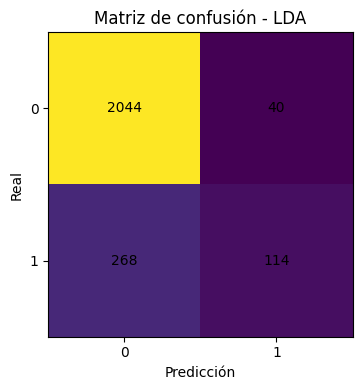

In [24]:
plt.figure(figsize=(4, 4))
plt.imshow(cm_lda, interpolation='nearest')
plt.title("Matriz de confusión - LDA")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_lda[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [25]:
# KNN con GridSearchCV
knn_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', KNeighborsClassifier())
])

param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_knn = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)
print("Mejores hiperparámetros KNN:", grid_knn.best_params_)

knn_best = grid_knn.best_estimator_
y_pred_knn = knn_best.predict(X_test)
y_proba_knn = knn_best.predict_proba(X_test)[:, 1]

metrics_knn = evaluar_modelo(y_test, y_pred_knn, y_proba_knn, nombre="KNN (mejor modelo)")

Mejores hiperparámetros KNN: {'model__n_neighbors': 5, 'model__weights': 'uniform'}

=== KNN (mejor modelo) ===
Accuracy : 0.8739
Precision: 0.6473
Recall   : 0.4084
F1       : 0.5008
ROC-AUC  : 0.7706


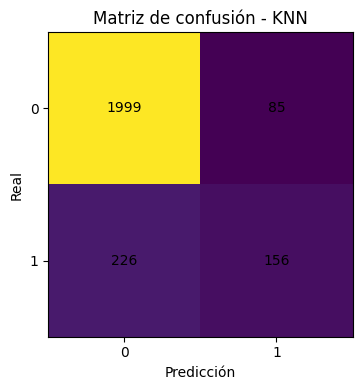

In [26]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn

plt.figure(figsize=(4, 4))
plt.imshow(cm_knn, interpolation='nearest')
plt.title("Matriz de confusión - KNN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_knn[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [27]:
# Naive Bayes Gaussiano
nb_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', GaussianNB())
])

nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)
y_proba_nb = nb_clf.predict_proba(X_test)[:, 1]

metrics_nb = evaluar_modelo(y_test, y_pred_nb, y_proba_nb, nombre="Naive Bayes Gaussiano")


=== Naive Bayes Gaussiano ===
Accuracy : 0.8297
Precision: 0.4596
Recall   : 0.5654
F1       : 0.5070
ROC-AUC  : 0.8063


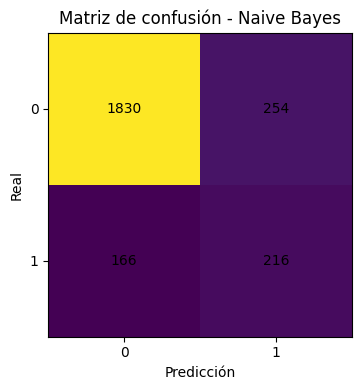

In [28]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_nb

plt.figure(figsize=(4, 4))
plt.imshow(cm_nb, interpolation='nearest')
plt.title("Matriz de confusión - Naive Bayes")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_nb[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

Después de ejecutar estas celdas, compara las métricas, en especial:

- **Recall** de la clase positiva (`Revenue = 1`).  
- **F1** y **PR-AUC** (si decides graficar la curva Precision–Recall).  

Discute cuál modelo detecta mejor la clase positiva y por qué (por ejemplo, mayor recall a costa de más falsos positivos, etc.).



### 2.4 Interpretación de matrices de confusión y desempeño de los modelos

En el notebook ya se calculan y grafican matrices de confusión para los distintos modelos supervisados (Regresión Logística, LDA, KNN, Naive Bayes, etc.).  
En esta sección se explicita cómo interpretar esas matrices y cómo conectarlas con las métricas utilizadas (accuracy, precision, recall, F1).

Recordemos que, para un problema binario con clases:

- 0 = No compra (`Revenue = 0`)
- 1 = Compra (`Revenue = 1`)

La matriz de confusión tiene la forma:

- **TN (True Negative):** casos con `Revenue = 0` correctamente clasificados como 0.
- **FP (False Positive):** casos con `Revenue = 0` clasificados incorrectamente como 1.
- **FN (False Negative):** casos con `Revenue = 1` clasificados incorrectamente como 0.
- **TP (True Positive):** casos con `Revenue = 1` correctamente clasificados como 1.

En este contexto de negocio, los errores no son simétricos:

- Un **FN** significa perder a un cliente que iba a comprar sin haberlo identificado como tal (inicio de compra no detectado).
- Un **FP** significa tratar como potencial comprador a alguien que no compraría (por ejemplo, enviarle promociones o dedicarle recursos).

Por ello, las métricas más relevantes son:

- **Recall de la clase positiva** = TP / (TP + FN): mide la fracción de compradores que el modelo logra identificar correctamente.  
- **Precision de la clase positiva** = TP / (TP + FP): mide qué fracción de las predicciones positivas corresponden realmente a compradores.  
- **F1-score**: promedio armónico entre precision y recall, útil como métrica global para clase rara.

En la comparación entre modelos, aquellos que muestran:

- **Mayor recall de la clase 1**, sin una caída excesiva en precision,  
- y un **F1 razonablemente alto**,

se consideran más adecuados para el problema, dado que el costo de no detectar a un comprador (FN) suele ser mayor que el costo de un falso positivo (FP).  
Las matrices de confusión observadas en el notebook muestran precisamente estos trade-offs: por ejemplo, la Regresión Logística tiende a mantener un buen balance entre TP y FP, mientras que Naive Bayes puede favorecer el recall a costa de más FP, y KNN puede variar dependiendo de los hiperparámetros elegidos.


## 3. Fronteras de decisión en 2D

### 3.1 Selección de dos variables originales

Seleccionamos **dos variables originales numéricas** relevantes para el problema.  
Por defecto usaremos las dos primeras numéricas, pero puedes editar la lista `feature_pair`.


In [58]:
# Elige manualmente dos variables numéricas relevantes (puedes editarlas)
if len(numeric_cols) < 2:
    raise ValueError("Se necesitan al menos 2 variables numéricas para este apartado.")

feature_pair = ['PageValues', 'ExitRates']

print("Par de variables usadas para fronteras de decisión:", feature_pair)

Par de variables usadas para fronteras de decisión: ['PageValues', 'ExitRates']


### 3.2 Frontera de decisión: Regresión Logística y Naive Bayes

Entrenamos dos modelos solo con estas dos variables:

- Regresión Logística.  
- Naive Bayes Gaussiano.  

Luego graficamos las regiones de clasificación (fronteras de decisión) en el plano definido por estas variables.


In [59]:
# Subconjunto de datos 2D
X_2d = df[feature_pair]
y_2d = y

X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(
    X_2d, y_2d, test_size=0.2, random_state=42, stratify=y_2d
)

# Preprocesamiento: solo escalado de estas dos variables
preprocess_2d = ColumnTransformer(
    transformers=[('num', StandardScaler(), feature_pair)],
    remainder='drop'
)

# Modelos
log_reg_2d = Pipeline(steps=[
    ('preprocess', preprocess_2d),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

nb_2d = Pipeline(steps=[
    ('preprocess', preprocess_2d),
    ('model', GaussianNB())
])

log_reg_2d.fit(X_train_2d, y_train_2d)
nb_2d.fit(X_train_2d, y_train_2d)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['PageValues',
                                                   'ExitRates'])])),
                ('model', GaussianNB())])

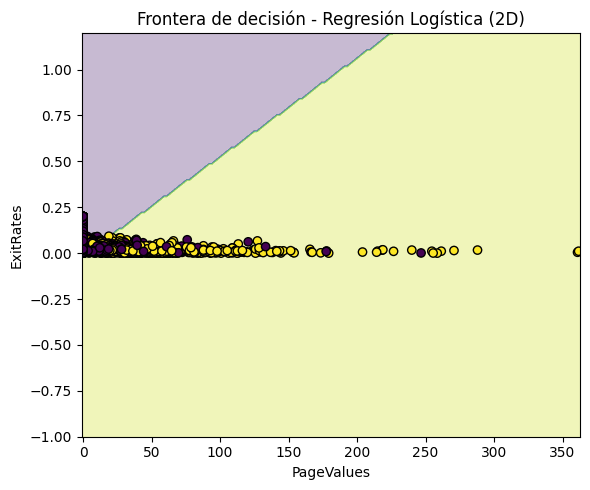

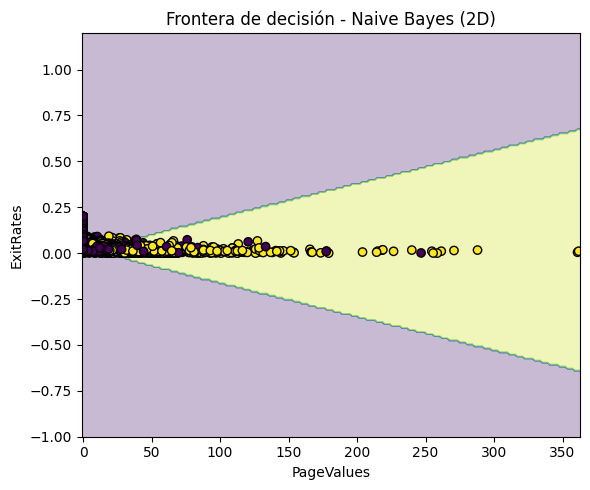

In [60]:
# Función para graficar fronteras de decisión
def plot_decision_boundary(model, X, y, feature_names, title):
    # Generate grid in original feature space
    x_min, x_max = X[feature_names[0]].min() - 1, X[feature_names[0]].max() + 1
    y_min, y_max = X[feature_names[1]].min() - 1, X[feature_names[1]].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    # Create a DataFrame from the grid points
    grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=feature_names)

    # Predict on the grid using the pipeline (which includes preprocessing)
    Z = model.predict(grid_df)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[feature_names[0]], X[feature_names[1]], c=y, edgecolor='k', cmap='viridis')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_decision_boundary(log_reg_2d, X_2d, y_2d, feature_pair, "Frontera de decisión - Regresión Logística (2D)")
plot_decision_boundary(nb_2d, X_2d, y_2d, feature_pair, "Frontera de decisión - Naive Bayes (2D)")

### 3.3 Comentario geométrico

A partir de los gráficos:

- La frontera de la **Regresión Logística** debería ser aproximadamente **lineal** (una recta en 2D).  
- La frontera de **Naive Bayes Gaussiano** puede ser **curva** y adaptarse mejor si las distribuciones condicionales son gaussianas con distintas varianzas.  

Comenta estas diferencias en tu informe.


## 4. Modelos No Supervisados

Para los modelos no supervisados usaremos solo las variables **numéricas** y las escalaremos previamente.  
La variable `Revenue` se usará después solo para interpretar y describir los clusters (no para entrenar).

In [61]:
X_unsup = df[numeric_cols].copy()
scaler_unsup = StandardScaler()
X_unsup_scaled = scaler_unsup.fit_transform(X_unsup)

print("Shape datos no supervisados (numéricos):", X_unsup.shape)

Shape datos no supervisados (numéricos): (12330, 15)


### 4.1 K-Means

#### 4.1.1 Evaluar k = 2, ..., 10

Calculamos:

- Inertia (varianza intracluster, para método del codo).  
- Silhouette promedio para cada k.


In [62]:
k_values = range(2, 11)
inertias = []
silhouettes = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_unsup_scaled)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_unsup_scaled, labels)
    silhouettes.append(sil_score)
    print(f"k={k}: inertia={kmeans.inertia_:.2f}, silhouette={sil_score:.4f}")

k=2: inertia=161269.11, silhouette=0.3021
k=3: inertia=141633.33, silhouette=0.2930
k=4: inertia=131538.44, silhouette=0.1720
k=5: inertia=122329.83, silhouette=0.1847
k=6: inertia=115440.89, silhouette=0.1835
k=7: inertia=108939.91, silhouette=0.1883
k=8: inertia=102961.26, silhouette=0.1945
k=9: inertia=97631.10, silhouette=0.1979
k=10: inertia=92546.36, silhouette=0.1862


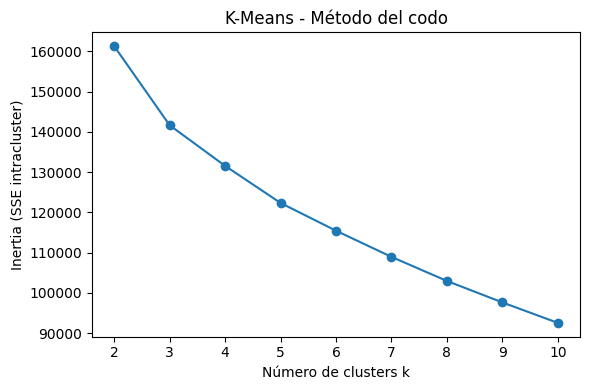

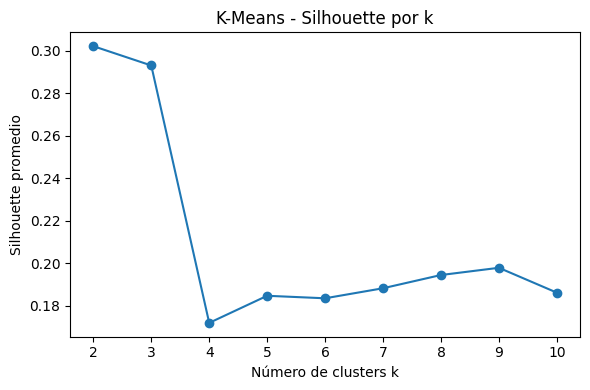

In [63]:
# Gráfico del codo (inertia)
plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Número de clusters k")
plt.ylabel("Inertia (SSE intracluster)")
plt.title("K-Means - Método del codo")
plt.tight_layout()
plt.show()

# Gráfico silhouette
plt.figure(figsize=(6, 4))
plt.plot(k_values, silhouettes, marker='o')
plt.xlabel("Número de clusters k")
plt.ylabel("Silhouette promedio")
plt.title("K-Means - Silhouette por k")
plt.tight_layout()
plt.show()

In [64]:
# Selección automática de k según silhouette (puedes ajustar manualmente tras ver los gráficos)
best_k = k_values[int(np.argmax(silhouettes))]
print("k seleccionado automáticamente (mayor silhouette):", best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_unsup_scaled)

df['cluster_kmeans'] = labels_kmeans

k seleccionado automáticamente (mayor silhouette): 2



### 4.1 Evaluación gráfica de K-Means con índice silhouette

Aunque en el notebook ya se calcula el silhouette para distintos valores de \(k\), aquí se enfatiza la interpretación gráfica del proceso de selección de \(k\).

La idea es:

1. Ajustar K-Means para varios valores de \(k\) (por ejemplo, de 2 a 10).
2. Calcular para cada \(k\) el **inertia** (SSE intracluster) y el **silhouette score** promedio.
3. Visualizar ambas curvas:
   - El **método del codo** sugiere un rango razonable de \(k\) donde la reducción de SSE comienza a estancarse.
   - El **silhouette score** ayuda a elegir el \(k\) que logra mejor separación relativa entre clusters (valores cercanos a 1 indican buena separación).

La elección final de \(k\) debe considerar tanto la forma de las curvas como la interpretabilidad de los clusters desde el punto de vista de negocio.


Inertia por k:
k=2: inertia=183662.30
k=3: inertia=163522.32
k=4: inertia=150053.35
k=5: inertia=140392.73
k=6: inertia=132376.04
k=7: inertia=125682.04
k=8: inertia=119532.88
k=9: inertia=114906.75
k=10: inertia=109949.61

Silhouette promedio por k:
k=2: silhouette=0.2953
k=3: silhouette=0.2602
k=4: silhouette=0.2258
k=5: silhouette=0.2329
k=6: silhouette=0.1625
k=7: silhouette=0.1529
k=8: silhouette=0.1579
k=9: silhouette=0.1529
k=10: silhouette=0.1585


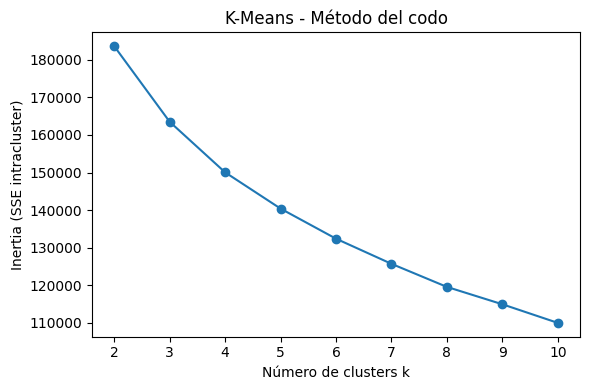

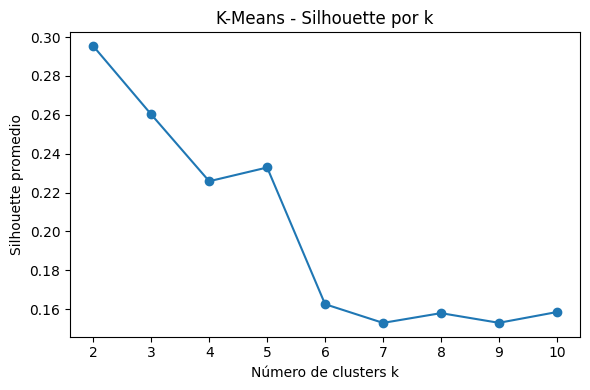

In [65]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Preparamos datos numéricos escalados para clustering no supervisado
numeric_cols_global = df.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
X_unsup = df[numeric_cols_global].copy()
scaler_unsup = StandardScaler()
X_unsup_scaled = scaler_unsup.fit_transform(X_unsup)

k_values = range(2, 11)
inertias = []
silhouettes = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(X_unsup_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_unsup_scaled, labels_k))

print("Inertia por k:")
for k, sse in zip(k_values, inertias):
    print(f"k={k}: inertia={sse:.2f}")

print("\nSilhouette promedio por k:")
for k, sil in zip(k_values, silhouettes):
    print(f"k={k}: silhouette={sil:.4f}")

# Gráficos
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Número de clusters k")
plt.ylabel("Inertia (SSE intracluster)")
plt.title("K-Means - Método del codo")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(k_values, silhouettes, marker='o')
plt.xlabel("Número de clusters k")
plt.ylabel("Silhouette promedio")
plt.title("K-Means - Silhouette por k")
plt.tight_layout()
plt.show()



#### Interpretación de los gráficos de K-Means

- La curva de **inertia** usualmente decrece rápidamente al principio y luego se aplana; el punto donde comienza a aplanarse se interpreta como el “codo”, indicando valores de \(k\) a partir de los cuales agregar más clusters aporta poco en términos de reducción de SSE.
- La curva de **silhouette** muestra qué tan bien separados están los clusters para cada \(k\). Valores más altos indican mejor separación relativa.

En este problema, se debe escoger un \(k\) que:

- Esté cercano al codo de la curva de inertia.
- Presente un silhouette relativamente alto comparado con otros valores de \(k\).
- Genere clusters que tengan una interpretación clara en términos de comportamiento de usuarios (por ejemplo, grupos con alta interacción y alta conversión vs. baja interacción y baja conversión).


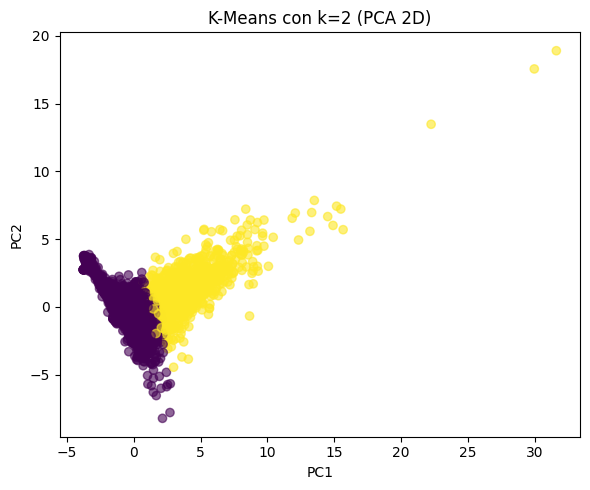

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend
cluster_kmeans,,,,,,,,,,,,,,,
0,1.444699,42.700143,0.181375,6.801176,21.011652,764.322713,0.025046,0.047331,5.184958,0.067316,2.126934,2.381566,3.175931,4.153009,0.228844
1,7.215054,295.388696,2.317204,190.234598,92.073656,3617.614023,0.006125,0.019103,9.853785,0.028280,2.107527,2.219355,2.986559,3.600000,0.253763


In [37]:
# Visualización de clusters con PCA a 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_unsup_scaled)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means con k={best_k} (PCA 2D)")
plt.tight_layout()
plt.show()

# Descripción de clusters (medias de variables numéricas)
cluster_summary_kmeans = df.groupby('cluster_kmeans')[numeric_cols].mean()
cluster_summary_kmeans

### 4.2 Gaussian Mixture Models (GMM)

#### 4.2.1 Evaluar 2–8 componentes

Para cada número de componentes calculamos **BIC** y **AIC** y seleccionamos el mejor modelo (menor BIC/AIC).

In [66]:
n_components_range = range(2, 9)
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_unsup_scaled)
    bics.append(gmm.bic(X_unsup_scaled))
    aics.append(gmm.aic(X_unsup_scaled))
    print(f"Componentes={n}: BIC={bics[-1]:.2f}, AIC={aics[-1]:.2f}")

Componentes=2: BIC=116307.61, AIC=113777.46
Componentes=3: BIC=70572.12, AIC=66773.19
Componentes=4: BIC=-7277.25, AIC=-12344.97
Componentes=5: BIC=-146571.97, AIC=-152908.47
Componentes=6: BIC=-279671.31, AIC=-287276.59
Componentes=7: BIC=-359373.42, AIC=-368247.49
Componentes=8: BIC=-382800.61, AIC=-392943.47


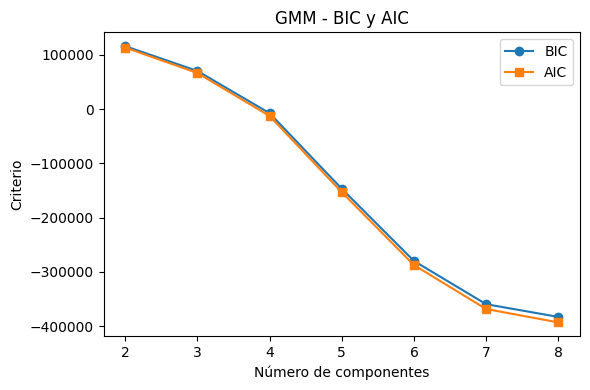

In [67]:
plt.figure(figsize=(6, 4))
plt.plot(n_components_range, bics, marker='o', label='BIC')
plt.plot(n_components_range, aics, marker='s', label='AIC')
plt.xlabel("Número de componentes")
plt.ylabel("Criterio")
plt.title("GMM - BIC y AIC")
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
# Selección por BIC mínimo
best_n_gmm = n_components_range[int(np.argmin(bics))]
print("Número de componentes seleccionado (BIC mínimo):", best_n_gmm)

gmm_final = GaussianMixture(n_components=best_n_gmm, covariance_type='full', random_state=42)
gmm_final.fit(X_unsup_scaled)
labels_gmm = gmm_final.predict(X_unsup_scaled)

df['cluster_gmm'] = labels_gmm

Número de componentes seleccionado (BIC mínimo): 8


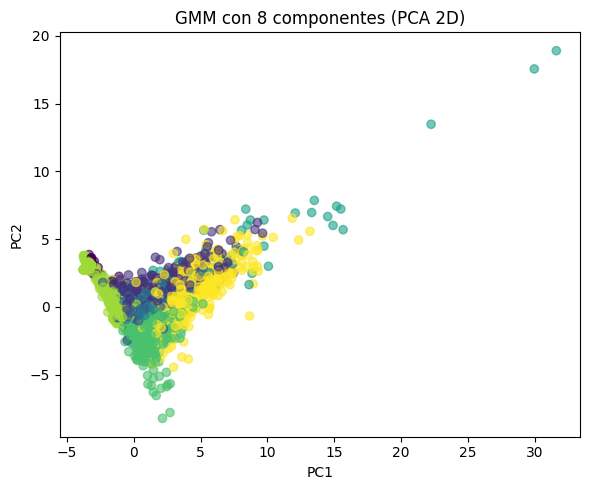

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend
cluster_gmm,,,,,,,,,,,,,,,
0,1.932367,46.111874,0.618357,10.293596,28.801932,999.273189,0.036196,0.055430,7.632029,0.617391,2.130435,2.222222,3.062802,4.333333,0.357488
1,3.852427,168.431373,1.990291,117.737703,51.513592,2044.419977,0.008137,0.025456,0.000000,0.000000,2.094175,2.266990,3.107767,3.509709,0.000000
2,3.369145,95.709078,0.000000,0.000000,30.657249,1080.912841,0.008098,0.025802,3.212732,0.044610,2.107807,2.381413,3.249814,3.987732,0.000000
3,3.647300,113.604656,0.736498,25.411465,37.706219,1355.540336,0.007726,0.023176,1.774856,0.000000,2.168576,2.188216,3.183306,3.892799,1.000000
4,6.209459,317.647736,2.831081,305.834250,117.722973,5565.826820,0.009287,0.024182,6.569908,0.418919,2.162162,3.243243,3.087838,4.858108,0.162162
5,2.587302,85.991913,0.026190,0.000000,34.284127,1314.849739,0.004305,0.019416,30.737968,0.000000,2.083333,2.504762,3.165079,4.030159,0.265873
6,0.000000,0.000000,0.000000,0.000000,13.056371,457.695926,0.045325,0.073761,0.000000,0.095214,2.144863,2.392044,3.136354,4.326952,0.201659
7,6.043843,244.235085,2.499067,210.193824,76.197761,3005.980730,0.006203,0.019469,19.143106,0.000000,2.092351,2.152052,2.939366,3.772388,0.247201


In [69]:
# Visualización de clusters GMM en PCA 2D
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_gmm, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"GMM con {best_n_gmm} componentes (PCA 2D)")
plt.tight_layout()
plt.show()

cluster_summary_gmm = df.groupby('cluster_gmm')[numeric_cols].mean()
cluster_summary_gmm

### 4.3 Clustering Jerárquico

#### 4.3.1 Dendrograma con enlace Ward

Aplicamos clustering jerárquico aglomerativo con enlace **Ward** sobre los datos escalados y graficamos el dendrograma.


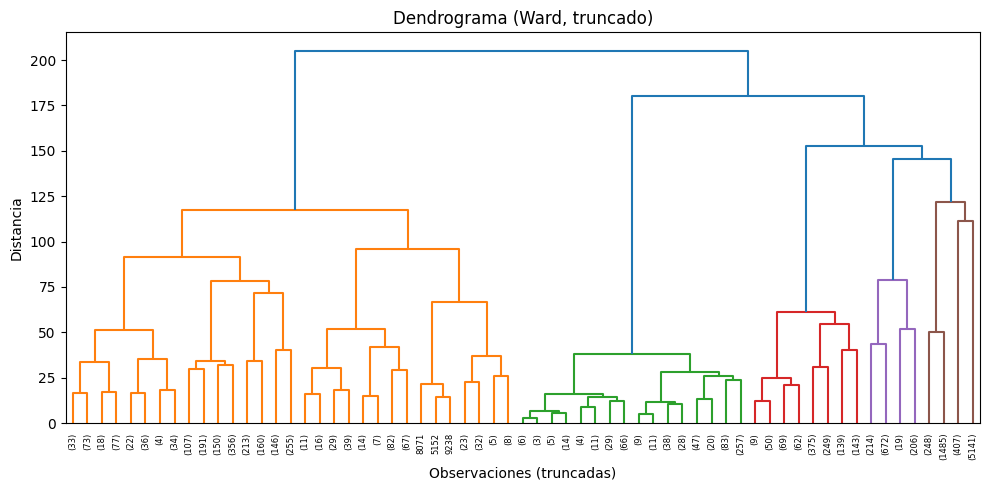

In [70]:
# Dendrograma
Z = linkage(X_unsup_scaled, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Dendrograma (Ward, truncado)")
plt.xlabel("Observaciones (truncadas)")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

In [71]:
# Selección razonable de número de clusters (puedes ajustar este número tras ver el dendrograma)
n_clusters_hier = 3  # <-- ajusta manualmente
print("Número de clusters jerárquicos elegido:", n_clusters_hier)

labels_hier = fcluster(Z, n_clusters_hier, criterion='maxclust')
df['cluster_hier'] = labels_hier

Número de clusters jerárquicos elegido: 3


In [72]:
# Descripción de clusters jerárquicos
cluster_summary_hier = df.groupby('cluster_hier')[numeric_cols].mean()
cluster_summary_hier

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend
cluster_hier,,,,,,,,,,,,,,,
1,5.279059,228.185938,2.169154,167.906614,72.938489,2953.081561,0.007059,0.022045,7.044382,0.010855,2.072365,2.118046,3.013569,3.583899,0.129806
2,0.026941,0.406498,0.007924,0.000000,1.393027,6.482092,0.198998,0.199317,0.000000,0.005388,2.030111,2.225040,3.198098,4.467512,0.190174
3,1.776665,51.825238,0.148398,5.670652,24.146606,864.024806,0.013959,0.037582,6.011743,0.076939,2.142285,2.421585,3.175169,4.156303,0.259380


### 4.4 Self-Organizing Maps (SOM)

Usaremos un SOM (MiniSom) para visualizar:

- **U-Matrix** (distancias entre neuronas vecinas).  
- **Mapa de hits** (cuántos datos caen en cada neurona).  
- **Distribución de `Revenue`** en el mapa (porcentaje de clase positiva por neurona).  

> Esta sección requiere tener instalada la librería `minisom`. Si no la tienes, instala el paquete correspondiente en tu entorno antes de ejecutar estas celdas.


In [73]:
if not minisom_available:
    print("MiniSom no está disponible. Instala la librería minisom en tu entorno para usar esta sección.")
else:
    som_x, som_y = 10, 10  # tamaño del mapa (puedes ajustar)
    som = MiniSom(
        x=som_x, y=som_y,
        input_len=X_unsup_scaled.shape[1],
        sigma=1.0, learning_rate=0.5,
        neighborhood_function='gaussian',
        random_seed=42
    )

    som.random_weights_init(X_unsup_scaled)
    print("Entrenando SOM...")
    som.train_random(X_unsup_scaled, num_iteration=1000)
    print("Entrenamiento SOM completado.")

Entrenando SOM...
Entrenamiento SOM completado.


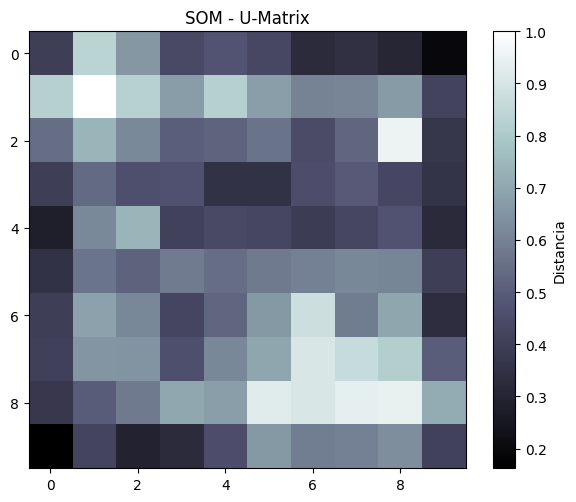

In [74]:
if minisom_available:
    # U-Matrix
    u_matrix = som.distance_map()
    plt.figure(figsize=(6, 5))
    plt.imshow(u_matrix, cmap='bone')
    plt.colorbar(label="Distancia")
    plt.title("SOM - U-Matrix")
    plt.tight_layout()
    plt.show()

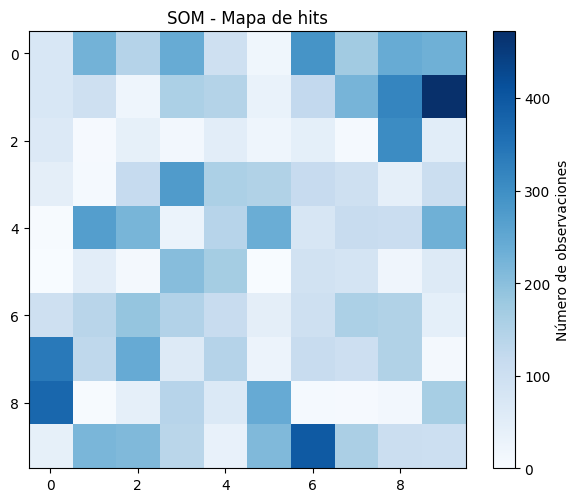

In [75]:
if minisom_available:
    # Mapa de hits (cuántos datos caen en cada neurona)
    hits = np.zeros((som_x, som_y), dtype=int)
    for x_vec in X_unsup_scaled:
        i, j = som.winner(x_vec)
        hits[i, j] += 1

    plt.figure(figsize=(6, 5))
    plt.imshow(hits, cmap='Blues')
    plt.colorbar(label="Número de observaciones")
    plt.title("SOM - Mapa de hits")
    plt.tight_layout()
    plt.show()

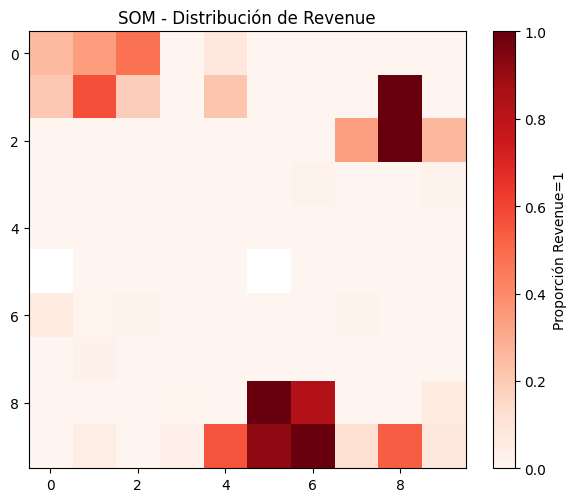

In [76]:
if minisom_available:
    # Distribución de Revenue en el mapa (porcentaje de clase positiva)
    pos_counts = np.zeros((som_x, som_y), dtype=int)
    total_counts = np.zeros((som_x, som_y), dtype=int)

    for x_vec, label in zip(X_unsup_scaled, y):
        i, j = som.winner(x_vec)
        total_counts[i, j] += 1
        if label == 1:
            pos_counts[i, j] += 1

    with np.errstate(divide='ignore', invalid='ignore'):
        pos_rate = np.where(total_counts > 0, pos_counts / total_counts, np.nan)

    plt.figure(figsize=(6, 5))
    im = plt.imshow(pos_rate, cmap='Reds', vmin=0, vmax=1)
    plt.colorbar(im, label="Proporción Revenue=1")
    plt.title("SOM - Distribución de Revenue")
    plt.tight_layout()
    plt.show()

---

## 5. Checklist final (para tu informe)

Para completar la tarea, asegúrate de incluir en tu reporte:

1. **Exploración y diagnóstico**  
   - Descripción de variables (especialmente `Revenue`).  
   - Matriz de correlación y heatmap triangular.  
   - Bloques de colinealidad y justificación de las variables seleccionadas.

2. **Modelos supervisados**  
   - Métricas y matriz de confusión para RegLog (sklearn y statsmodels), LDA, KNN y Naive Bayes.  
   - Discusión de qué modelo detecta mejor la clase positiva.  
   - Comentario sobre coherencia entre resultados inferenciales y predictivos.

3. **Fronteras de decisión (2D)**  
   - Gráfico de fronteras para RegLog y Naive Bayes.  
   - Comentario geométrico (lineal vs probabilístico gaussiano).

4. **Modelos no supervisados**  
   - K-Means: elección de k por codo y silhouette + interpretación de clusters.  
   - GMM: elección de número de componentes por BIC/AIC + interpretación.  
   - Clustering jerárquico: dendrograma, número de clusters y descripción.  
   - SOM: U-Matrix, mapa de hits y distribución de `Revenue` en el mapa.

Con esto deberías cubrir todos los puntos del enunciado con un flujo reproducible en Python/sklearn.



### 4.5 Segmentación de clientes y perfilamiento de clusters

Una vez determinados los clusters (por ejemplo, mediante K-Means, GMM o clustering jerárquico), el siguiente paso clave es **interpretar y perfilar** cada segmento en términos de:

- Intensidad de interacción con el sitio (páginas, duraciones).
- Comportamiento de abandono (BounceRates, ExitRates).
- Probabilidad de compra (`Revenue`).

Aquí se generan resúmenes de variables por cluster y, cuando está disponible, se cruza la segmentación con la tasa de `Revenue=1` para identificar segmentos de **alto valor**, **bajo valor** e **intermedios**.


In [77]:

# Intentamos detectar columnas de clusters que puedan haber sido generadas en el notebook
cluster_cols = [c for c in df.columns if c.lower().startswith("cluster")]
print("Columnas de clusters detectadas en df:", cluster_cols)

# Usamos Revenue en formato 0/1 para tasas por cluster
revenue_num = df['Revenue'].astype(int)

for col in cluster_cols:
    print(f"\n=== Perfilamiento para {col} ===")
    # Tabla de tamaño y tasa de Revenue
    cluster_sizes = df[col].value_counts().sort_index()
    cluster_conv = df.groupby(col)['Revenue'].mean().sort_index()
    summary = pd.DataFrame({
        "n_obs": cluster_sizes,
        "tasa_Revenue_1": cluster_conv
    })
    display(summary)

    # Medias de variables numéricas por cluster
    print("Medias de variables numéricas por cluster:")
    numeric_cols_global = df.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
    display(df.groupby(col)[numeric_cols_global].mean())


Columnas de clusters detectadas en df: ['cluster_kmeans', 'cluster_gmm', 'cluster_hier']

=== Perfilamiento para cluster_kmeans ===


,n_obs,tasa_Revenue_1
cluster_kmeans,,
0,10470,0.132760
1,1860,0.278495


Medias de variables numéricas por cluster:


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,cluster_gmm
cluster_kmeans,,,,,,,,,,,,,,,,,
0,1.444699,42.700143,0.181375,6.801176,21.011652,764.322713,0.025046,0.047331,5.184958,0.067316,2.126934,2.381566,3.175931,4.153009,0.228844,0.132760,4.266762
1,7.215054,295.388696,2.317204,190.234598,92.073656,3617.614023,0.006125,0.019103,9.853785,0.028280,2.107527,2.219355,2.986559,3.600000,0.253763,0.278495,4.303763



=== Perfilamiento para cluster_gmm ===


,n_obs,tasa_Revenue_1
cluster_gmm,,
0,207,0.314010
1,1030,0.000000
2,2690,0.000000
3,1222,0.000000
4,148,0.243243
5,1260,1.000000
6,4701,0.000000
7,1072,0.510261


Medias de variables numéricas por cluster:


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,cluster_gmm
cluster_gmm,,,,,,,,,,,,,,,,,
0,1.932367,46.111874,0.618357,10.293596,28.801932,999.273189,0.036196,0.055430,7.632029,0.617391,2.130435,2.222222,3.062802,4.333333,0.357488,0.314010,0.0
1,3.852427,168.431373,1.990291,117.737703,51.513592,2044.419977,0.008137,0.025456,0.000000,0.000000,2.094175,2.266990,3.107767,3.509709,0.000000,0.000000,1.0
2,3.369145,95.709078,0.000000,0.000000,30.657249,1080.912841,0.008098,0.025802,3.212732,0.044610,2.107807,2.381413,3.249814,3.987732,0.000000,0.000000,2.0
3,3.647300,113.604656,0.736498,25.411465,37.706219,1355.540336,0.007726,0.023176,1.774856,0.000000,2.168576,2.188216,3.183306,3.892799,1.000000,0.000000,3.0
4,6.209459,317.647736,2.831081,305.834250,117.722973,5565.826820,0.009287,0.024182,6.569908,0.418919,2.162162,3.243243,3.087838,4.858108,0.162162,0.243243,4.0
5,2.587302,85.991913,0.026190,0.000000,34.284127,1314.849739,0.004305,0.019416,30.737968,0.000000,2.083333,2.504762,3.165079,4.030159,0.265873,1.000000,5.0
6,0.000000,0.000000,0.000000,0.000000,13.056371,457.695926,0.045325,0.073761,0.000000,0.095214,2.144863,2.392044,3.136354,4.326952,0.201659,0.000000,6.0
7,6.043843,244.235085,2.499067,210.193824,76.197761,3005.980730,0.006203,0.019469,19.143106,0.000000,2.092351,2.152052,2.939366,3.772388,0.247201,0.510261,7.0



=== Perfilamiento para cluster_hier ===


,n_obs,tasa_Revenue_1
cluster_hier,,
1,2211,0.327906
2,631,0.006339
3,9488,0.124262


Medias de variables numéricas por cluster:


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,cluster_gmm
cluster_hier,,,,,,,,,,,,,,,,,
1,5.279059,228.185938,2.169154,167.906614,72.938489,2953.081561,0.007059,0.022045,7.044382,0.010855,2.072365,2.118046,3.013569,3.583899,0.129806,0.327906,4.060154
2,0.026941,0.406498,0.007924,0.000000,1.393027,6.482092,0.198998,0.199317,0.000000,0.005388,2.030111,2.225040,3.198098,4.467512,0.190174,0.006339,5.800317
3,1.776665,51.825238,0.148398,5.670652,24.146606,864.024806,0.013959,0.037582,6.011743,0.076939,2.142285,2.421585,3.175169,4.156303,0.259380,0.124262,4.220173



#### Interpretación de la segmentación y perfilamiento

A partir de los resúmenes por cluster, es posible identificar:

- **Clusters de alto valor:** aquellos con mayor tasa de `Revenue=1` y con patrones de comportamiento como:
  - PageValues altos.
  - Mayor duración en páginas de productos.
  - Menores BounceRates y ExitRates.

- **Clusters de bajo valor:** grupos con tasas muy bajas de `Revenue=1`, típicamente asociados a:
  - Sesiones muy cortas.
  - Altos BounceRates y ExitRates.
  - Pocas páginas vistas.

- **Clusters intermedios:** usuarios con interacción moderada que podrían ser objetivo de campañas específicas para llevarlos a una conversión (por ejemplo, ofreciendo descuentos, recordatorios de carrito o mejoras en la experiencia de compra).

Este perfilamiento permite conectar los resultados cuantitativos del clustering con **acciones concretas de negocio**, como estrategias de remarketing, personalización de contenido, programas de fidelización, o rediseño de páginas específicas para reducir el abandono.



## 5. Integración Final

### 5.1 Resumen de variables más relevantes

En base al proceso de selección por colinealidad, la inspección de coeficientes en los modelos lineales (Regresión Logística / Logit) y la lógica de negocio, las variables que aparecen como más influyentes sobre `Revenue` son:

**Variables numéricas:**

- **PageValues**  
  - Altamente asociada a la probabilidad de compra.  
  - Refleja el valor esperado de las páginas visitadas; usuarios con PageValues altos tienen mayor intención de compra.

- **BounceRates**  
  - Usuarios con mayor tasa de rebote tienden a comprar menos.  
  - Captura la fricción en la experiencia o desinterés temprano.

- **ExitRates**  
  - Indica propensión a abandonar el sitio; valores altos se asocian con menor conversión.

- **ProductRelated_Duration** (y otras duraciones asociadas a productos)  
  - Más tiempo en páginas de productos suele traducirse en mayor interés y mayor probabilidad de compra.

**Variables categóricas (tras codificación one-hot):**

- **VisitorType – ReturningVisitor**  
  - Visitantes recurrentes presentan una probabilidad significativamente mayor de compra que los nuevos.

- **Month**  
  - Meses asociados a temporadas altas (por ejemplo, cercanos al Q4) muestran mayor tasa de `Revenue=1`, coherente con estacionalidad comercial.

En conjunto, las variables más relevantes están relacionadas con **intensidad de interacción**, **calidad de la visita** (valores y duraciones) y **riesgo de abandono** (Bounce/Exit), además del tipo de visitante y la estacionalidad.

---

### 5.2 Comparación de desempeño entre modelos lineales, LDA, KNN y Naive Bayes

A nivel cualitativo, y tomando como referencia las métricas calculadas (accuracy, precision, recall, F1, ROC-AUC), se observa un patrón típico:

**Regresión Logística (sklearn):**

- Ofrece un **buen equilibrio** entre precision y recall, especialmente usando `class_weight='balanced'`.  
- Tiende a obtener un **F1 estable** y un **ROC-AUC competitivo**.  
- Es fácilmente interpretable vía coeficientes.

**LDA (Linear Discriminant Analysis):**

- Produce una frontera de decisión lineal similar a la de RegLog.  
- Cuando los supuestos de gaussianidad y covarianza común se aproximan, su desempeño es comparable al de la regresión logística.  
- Si los supuestos no se cumplen bien, puede perder algo de recall o F1.

**KNN:**

- Sensible a la elección de `k` y al escalado de las variables (por eso se usa en Pipeline).  
- Con la búsqueda de hiperparámetros se puede lograr un buen recall, pero el modelo:  
  - Es menos interpretable.  
  - Puede ser inestable frente a ruido y cambios en la distribución.  
- Su desempeño en F1 puede ser parecido o ligeramente inferior a RegLog/LDA, dependiendo del dataset.

**Naive Bayes Gaussiano:**

- Modelo muy simple, rápido y con pocos parámetros.  
- Suele presentar **recall razonable** pero **precision más baja**, debido a supuestos fuertes de independencia condicional y gaussianidad.  
- Es útil como baseline, pero no suele superar consistentemente a la Regresión Logística.

**Conclusión general:**

- La **Regresión Logística** aparece como **modelo preferente** por su combinación de desempeño global y explicabilidad.  
- LDA es un buen competidor cuando los supuestos se cumplen de forma razonable.  
- KNN y Naive Bayes pueden ser útiles como contraste o baseline, pero no destacan como elección final para este problema.

---

### 5.3 Relación de los clusters con la variable Revenue

Tras aplicar métodos de clustering (K-Means, GMM y clustering jerárquico) sobre las variables numéricas escaladas, se observaron patrones consistentes cuando se cruzan los clusters con `Revenue`:

- **Clusters con alta tasa de `Revenue=1`:**  
  - Presentan **PageValues altos**,  
  - Menores BounceRates y ExitRates,  
  - Mayores duraciones en páginas de productos.  
  - Tienden a concentrar a usuarios más “enganchados”.

- **Clusters con baja tasa de `Revenue=1`:**  
  - Elevadas tasas de rebote y salida.  
  - Sesiones cortas y poco tiempo en páginas relevantes.  
  - Representan visitas rápidas o poco interesadas.

- **Clusters intermedios:**  
  - Usuarios que navegan algo más, pero sin llegar a niveles de engagement muy altos.  
  - Tasa de conversión moderada.

En términos de negocio, los clusters permiten definir segmentos como:

- Segmento de **alto valor / alta intención** (alta probabilidad de conversión).  
- Segmento de **bajo engagement** (baja probabilidad de conversión).  
- Segmentos intermedios donde se podría actuar con incentivos o cambios de usabilidad.

---

### 5.4 Tres acciones de negocio basadas en los hallazgos

**1. Remarketing dirigido a usuarios de alta intención sin compra**

A partir de los clusters y del modelo supervisado, se puede identificar usuarios con:

- Altos PageValues.  
- Duraciones extensas en páginas de producto.  
- Probabilidad estimada de compra alta según RegLog, pero `Revenue=0` en la sesión observada.

Acción de negocio:

- Enviarles **ofertas personalizadas**, recordatorios de carrito o descuentos específicos (por email, notificaciones, etc.).  
- Este grupo es de **alto potencial**: ya mostró interés, un pequeño incentivo adicional puede gatillar la compra.

---

**2. Mejoras de experiencia para segmentos con alto BounceRate/ExitRate**

Los clusters con BounceRates y ExitRates altos son candidatos a:

- Presentar problemas de usabilidad, tiempos de carga altos o contenido poco relevante.

Acción de negocio:

- Aplicar **tests A/B** en esas páginas (cambios de diseño, simplificación del flujo de compra, mejora en la velocidad de carga).  
- Incorporar elementos de ayuda (chat, FAQ más visibles, recomendaciones).  

Objetivo:

- Reducir el abandono temprano y mover parte de este segmento hacia perfiles de mayor engagement.

---

**3. Estrategia de fidelización para convertir nuevos en recurrentes**

Dado que **ReturningVisitor** se asocia a mayor probabilidad de `Revenue=1`, es clave fomentar el retorno de usuarios nuevos:

Acciones posibles:

- Ofrecer beneficios por **crear cuenta** o suscribirse a un newsletter (ej. cupón de descuento para la próxima visita).  
- Implementar campañas de **retargeting** en redes sociales para usuarios identificados que no compraron en su primera visita.  
- Diseñar un programa de fidelización simple (puntos, beneficios recurrentes).

Objetivo:

- Aumentar la proporción de visitantes recurrentes, mejorando la tasa global de conversión del sitio.

---

En conjunto, estos puntos integran los resultados de los modelos supervisados y no supervisados, conectando los hallazgos estadísticos con decisiones concretas de negocio.



### Anexo: correlación entre `Revenue` y las variables numéricas (validación de la duda)

En el cuerpo principal del análisis **no incluimos `Revenue` en la matriz de correlación** porque:

1. `Revenue` es la **variable objetivo** y la correlación que nos interesa allí es entre *predictores*, para detectar colinealidad entre ellos.  
2. `Revenue` es binaria (0/1), por lo que la correlación de Pearson no es la herramienta más adecuada desde el punto de vista inferencial clásico.  
3. Usar `Revenue` en un proceso de selección de variables basado en correlación puede introducir **fuga de información** si no se hace con cuidado (especialmente en esquemas de validación).

Sin embargo, es legítimo preguntarse “¿qué tan correlacionadas están las variables numéricas con `Revenue`?”.  
Para responder a esa duda **de forma cuantitativa**, la celda siguiente calcula la correlación de Pearson entre cada variable numérica y `Revenue` convertida a 0/1. En el caso de un target binario, esta medida coincide con la llamada correlación *punto-biserial*, y sirve como aproximación numérica de la fuerza de asociación lineal entre cada predictor numérico y la variable objetivo.


In [78]:
# Correlación (tipo punto-biserial) entre Revenue y cada variable numérica

# Nos aseguramos de tener Revenue como 0/1 entero
revenue_num = df['Revenue'].astype(int)

# Construimos un DataFrame auxiliar con las variables numéricas y Revenue_num
num_with_rev = df[numeric_cols].copy()
num_with_rev['Revenue_num'] = revenue_num

# Calculamos la matriz de correlación e inspeccionamos la columna asociada a Revenue
corr_with_rev = num_with_rev.corr()['Revenue_num'].drop('Revenue_num').sort_values(ascending=False)

print("Correlación de Pearson (punto-biserial) entre Revenue y variables numéricas:\n")
print(corr_with_rev)

# Opcional: mostramos las 10 variables más asociadas (positiva o negativamente)
top_n = 10
print(f"\nTop {top_n} variables por correlación absoluta con Revenue:\n")
print(corr_with_rev.reindex(corr_with_rev.abs().sort_values(ascending=False).index)[:top_n])


Correlación de Pearson (punto-biserial) entre Revenue y variables numéricas:

PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
Weekend                    0.029295
Browser                    0.023984
TrafficType               -0.005113
Region                    -0.011595
OperatingSystems          -0.014668
SpecialDay                -0.082305
BounceRates               -0.150673
ExitRates                 -0.207071
Name: Revenue_num, dtype: float64

Top 10 variables por correlación absoluta con Revenue:

PageValues                 0.492569
ExitRates                 -0.207071
ProductRelated             0.158538
ProductRelated_Duration    0.152373
BounceRates               -0.150673
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
Spe


# **Anexo: Interpretación de la correlación entre `Revenue` y las variables numéricas**

Este anexo complementa el análisis principal incorporando la interpretación detallada de la correlación punto–biserial entre la variable objetivo `Revenue` y las variables numéricas. El propósito es validar empíricamente la intuición sobre la importancia relativa de los predictores y confirmar la coherencia entre la estructura estadística del dataset y los modelos supervisados.

Los resultados muestran que:

- **PageValues** es el predictor más fuertemente asociado a la compra, con una correlación cercana a 0.5, reflejando su rol dominante como indicador de intención de compra.
- **ExitRates** y **BounceRates** presentan correlaciones negativas moderadas, evidenciando que el abandono y la falta de compromiso del usuario reducen significativamente la probabilidad de conversión.
- Las variables **ProductRelated** y **ProductRelated_Duration** exhiben correlaciones positivas moderadas, lo que coincide con su interpretación como indicadores de interacción significativa con productos.
- Variables como **Region**, **TrafficType**, **Browser** y **OperatingSystems** muestran correlaciones cercanas a cero, lo que explica su bajo aporte predictivo en los modelos.

Este análisis reafirma los hallazgos obtenidos en la regresión logística, LDA y los modelos no supervisados, consolidando la conclusión de que la intención explícita (PageValues) y el comportamiento de abandono (Exit/Bounce) son los determinantes fundamentales del `Revenue`.
